<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As we'll see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 181 ms, sys: 58.5 ms, total: 240 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.36 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 291 ms, sys: 16.2 ms, total: 307 ms
Wall time: 2.16 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [8]:
z

Delayed('add-4bcf1268-9537-42e4-bd32-a721286d5ee1')

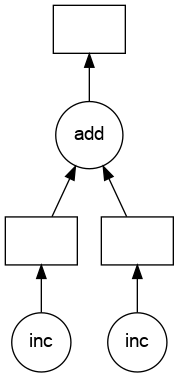

In [10]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
    - Looking the graph vertically, each steps/circle/function takes 1s. There two steps, so we can only shrink to 2s.
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
    - Yes, it can. But I think the time speed up is limited and probably the same as not using dask. Since dask need schedulers to distribute jobs and the function is really tiny.
-  What if we have multiple outputs or also want to get access to x or y?
    - Multiple outputs will failed with TypeError: Delayed objects of unspecified length are not iterable.

In [7]:
from time import sleep

def MyInc(x):
    sleep(1)
    return x + 1

def MyAdd(x, y):
    sleep(1)
    return x, y, x + y

MyX = delayed(MyInc)(10)
MyY = delayed(MyInc)(11)
MyOutput = delayed(MyAdd)(MyX, MyY)  # This won't have error.
FromX, FromY, MyZ = delayed(MyAdd)(MyX, MyY)  # This will reach TypeError: Delayed objects of unspecified length are not iterable.

TypeError: Delayed objects of unspecified length are not iterable

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [20]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [24]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 211 ms, sys: 65.4 ms, total: 276 ms
Wall time: 8.01 s


In [25]:
total

44

CPU times: user 4 ms, sys: 5.35 ms, total: 9.35 ms
Wall time: 41.1 ms


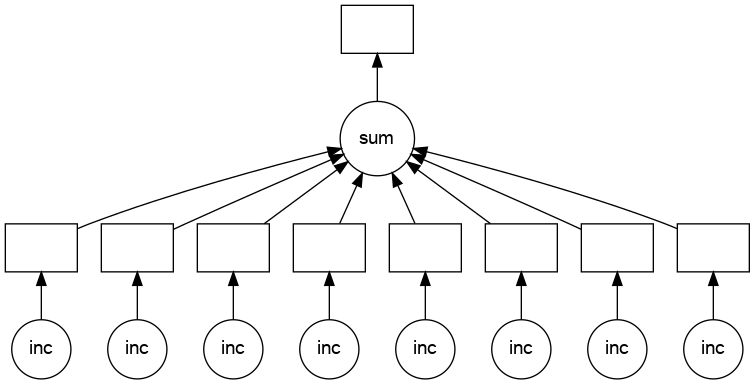

In [36]:
%%time
# Think like a graph...
# We cannot wrap append with delayed, as it can't draw in graph, and cannot work in parallel.
# Square is data element to compute in parallel, and circle is function that acts on data elements.
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()

In [35]:
%%time

total.compute()

CPU times: user 44.1 ms, sys: 6.1 ms, total: 50.2 ms
Wall time: 1.02 s


44

In [37]:
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('add-1bb82476b8e34b13b74bcb7a8da963a7')
After computing : 44


- How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
    ```python
    delayed(inc)(1) + delayed(inc)(2)
    ```
    - Since `sum` does not parallel, and it is used to add everyone together. So it needs to wait the other data element for adding.

CPU times: user 5.82 ms, sys: 4.53 ms, total: 10.4 ms
Wall time: 61.7 ms


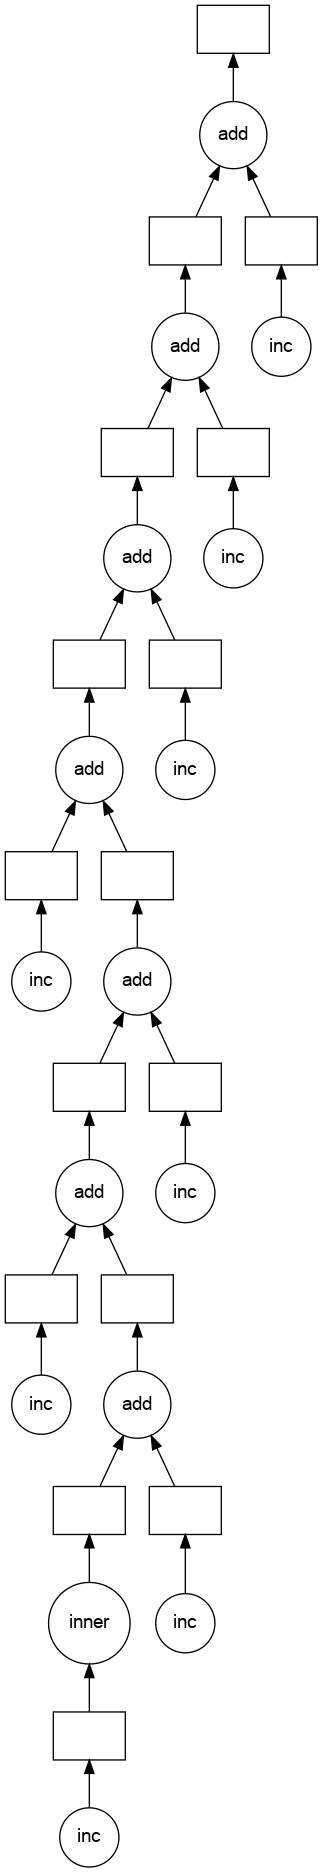

In [38]:
%%time
# What if sum does not wrap with delayed...?
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = sum(results)
total.visualize()

In [39]:
%%time

total.compute()

CPU times: user 57.1 ms, sys: 12.1 ms, total: 69.2 ms
Wall time: 1.06 s


44

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [16]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 735 ms, sys: 107 ms, total: 842 ms
Wall time: 10 s


CPU times: user 5.79 ms, sys: 9.46 ms, total: 15.3 ms
Wall time: 44.7 ms


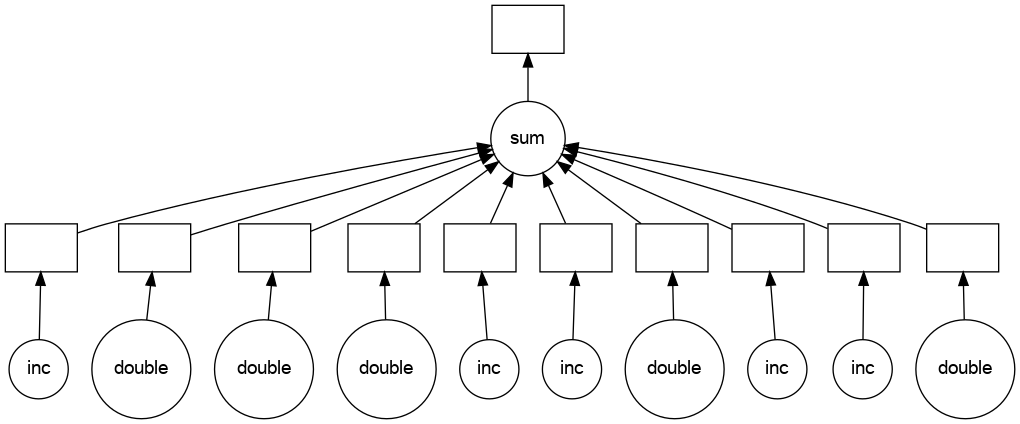

In [17]:
%%time
# Parallel with dask
# Some functions need to be run immediately, so that dask can build the schedule graph.
# Even if we add delayed(is_even)(x), we will meet error Truth object blablabla...
results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()

In [ ]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [18]:
%time total.compute()

CPU times: user 108 ms, sys: 16.7 ms, total: 125 ms
Wall time: 1.05 s


90

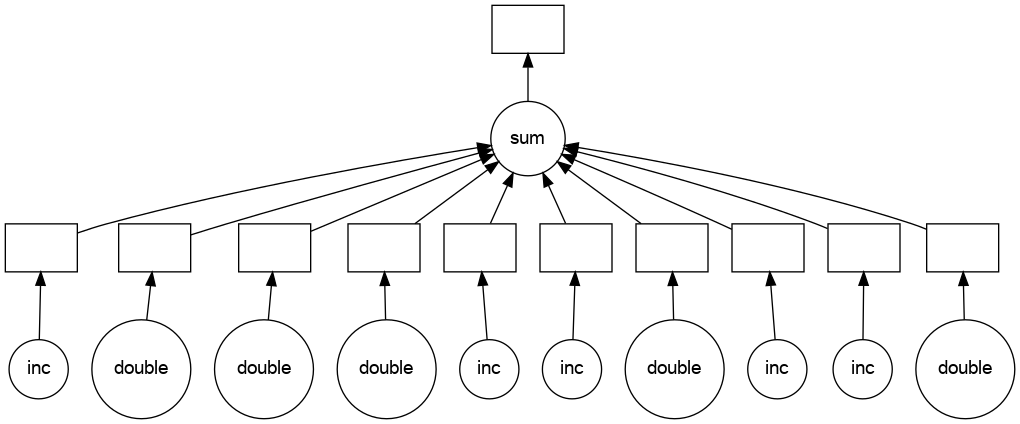

In [19]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

## Create data

Run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [ ]:
%run prep.py -d flights

### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

In [ ]:
# What is the schema?
df.dtypes

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
from dask import compute

In [ ]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

In [ ]:
%%time
# your code here

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
# ensure the results still match
mean

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [20]:
client.close()